In [81]:
import urbs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)
import seaborn as sns
sns.set_theme(style="whitegrid")

In [16]:
years = [2025, 2030, 2035, 2040, 2045, 2050]

In [17]:
df = {}
for year in years:
    df[year] = urbs.load(f"myopic/output/output_bayern_{year}.h5")._result

In [120]:
year = 2050

In [121]:
df[year].keys()

dict_keys(['cap_pro', 'cap_pro_new', 'cap_sto_c', 'cap_sto_c_new', 'cap_sto_p', 'cap_sto_p_new', 'com', 'com_buy', 'com_demand', 'com_env', 'com_sell', 'com_stock', 'com_supim', 'com_tuples', 'com_type', 'cost_type', 'costs', 'def_costs', 'def_initial_storage_state', 'def_intermittent_supply', 'def_partial_process_input', 'def_partial_process_output', 'def_process_input', 'def_process_output', 'def_storage_energy_power_ratio', 'def_storage_state', 'dt', 'e_co_buy', 'e_co_sell', 'e_co_stock', 'e_pro_in', 'e_pro_out', 'e_sto_con', 'e_sto_in', 'e_sto_out', 'obj', 'pro', 'pro_area_tuples', 'pro_input_tuples', 'pro_maxgrad_tuples', 'pro_output_tuples', 'pro_partial_input_tuples', 'pro_partial_output_tuples', 'pro_partial_tuples', 'pro_timevar_output_tuples', 'pro_tuples', 'res_area', 'res_buy_step', 'res_buy_total', 'res_env_step', 'res_env_total', 'res_global_co2_limit', 'res_process_capacity', 'res_process_maxgrad_lower', 'res_process_maxgrad_upper', 'res_process_throughput_by_capacity', 

In [122]:
# Useful duals

# "res_global_co2_limit" -> shows the dual of the co2 limit
# "res_process_capacity" -> shows the dual of the process maximal capacity constraint
# "res_storage_capacity" -> shows the dual of the storage maximal capacity constraint

In [125]:
sto_in = (df[year]['e_sto_in']
          .unstack()['Elec']
          .unstack()
          .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
          .sum(axis = 1))
sto_out = (df[year]['e_sto_out']
           .unstack()['Elec']
           .unstack()
           .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
           .sum(axis = 1))

In [126]:
def fourier_plot(data, comm, tech):
    # Convert storage level data
    df = (data['e_sto_con']
       .unstack()[comm]
       .dropna()
       .unstack()
       .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8761))
       )
    
    # Calculate SOC, and de-mean the timeseries data
    soc = (df[tech] - np.mean(df[tech])) / np.max(df[tech])
    n = len(soc)
    # Calculate FFT vector, power density vector, and frequency
    fhat = np.fft.fft(soc, n)
    PSD = fhat * np.conj(fhat) / n
    freq = (1/n) * np.arange(n)

    # Create a pairplot with the modified SOC and FFT components
    fig, axs = plt.subplots(2, 1)

    plt.sca(axs[0])
    plt.plot(soc)

    plt.sca(axs[1])
    plt.plot(freq[0:200], PSD[0:200])

    plt.suptitle(f"Seasonality of {tech}")

In [127]:
#fourier_plot(df[year], 'Process heating A', 'Process heat storage A')
#fourier_plot(df[year], 'Process heating B', 'Process heat storage B')
#fourier_plot(df[year], 'Space heating', 'Space heating storage')
#fourier_plot(df[year], 'Elec', 'Pump storage')
#fourier_plot(df[year], 'Elec', 'Battery')

In [168]:
# Electricity generation
gen = (df[year]['e_pro_out']
        .unstack()['Elec']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        )

In [169]:
# Electricity consumption
con = (df[year]['e_pro_in']
        .unstack()['Elec']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        )

In [170]:
# Process heating A consumption
con_phA = (df[year]['e_pro_out']
 .unstack()['Process heating A']
 .dropna()
 .unstack()
 .reorder_levels(['stf', 'sit', 't'])
 .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
 )

In [167]:
# Process heating B consumption
con_phB = (df[year]['e_pro_out']
 .unstack()['Process heating B']
 .dropna()
 .unstack()
 .reorder_levels(['stf', 'sit', 't'])
 .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
 )

In [ ]:
gen_ph = ()

Text(0.5, 1.0, 'Electricity consumption in MW, day 300 of 2050')

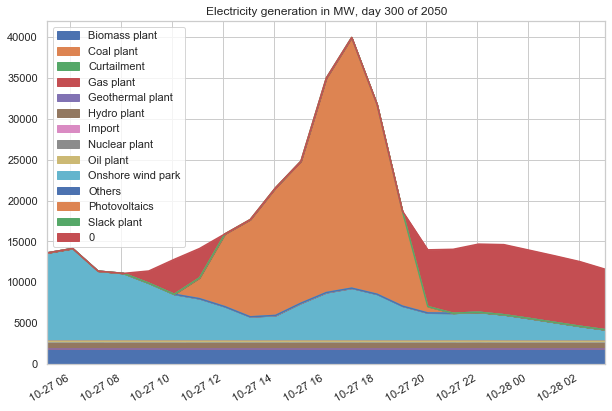

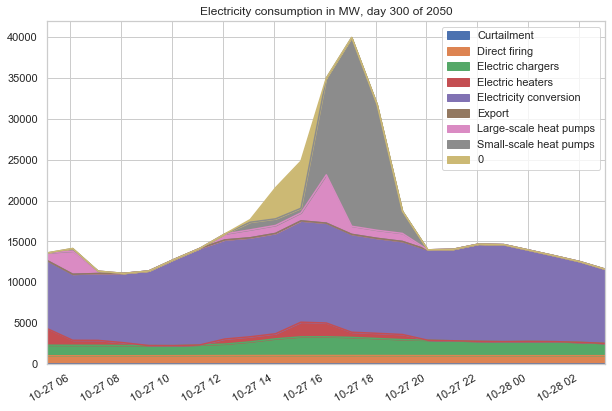

In [159]:
# Create case-study plot for electricity
day = 300
gen.join(pd.DataFrame(sto_out)).iloc[0 + day*24 : 23 + day*24, :].plot(kind = "area")
plt.title(f"Electricity generation in MW, day {day} of {year}")
con.join(pd.DataFrame(sto_in)).iloc[0 + day*24 : 23 + day*24, :].plot(kind = "area")
plt.title(f"Electricity consumption in MW, day {day} of {year}")

In [172]:
#ax = (gen / 1e6).resample('M').sum().plot(kind = 'area')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title(f'Monthly electricity generation in TWh ({year})')

In [135]:
gen_cap = df[year]['cap_pro'].unstack()[gen.columns].drop(['Curtailment', 'Slack plant', 'Import'], axis = 1)
con_cap = df[year]['cap_pro'].unstack()[con.columns].drop(['Curtailment', 'Export'], axis = 1)

In [136]:
#gen_cap.replace(0,np.nan).dropna(axis=1,how="all").plot.barh()
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title(f'Electricity generation capacity in MW ({year})')

In [137]:
#con_cap.replace(0,np.nan).dropna(axis=1,how="all").plot.barh()
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title(f'Electricity consumption capacity in MW ({year})')

In [138]:
sto_cap_c = df[year]['cap_sto_c'].unstack()
#sto_cap_c.replace(0,np.nan).dropna(axis=1,how="all").plot.barh(stacked = True)
#plt.title(f'Energy storage energy capacity in MWh ({year})')

In [139]:
sto_cap_p = df[year]['cap_sto_p'].unstack()
#sto_cap_p.replace(0,np.nan).dropna(axis=1,how="all").plot.barh(stacked = True)
#plt.title(f'Energy storage power capacity in MW ({year}')

In [140]:
sto_c_y = {}
sto_p_y = {}

for year in years:
    sto_c_y[year] = df[year]['cap_sto_c'].unstack()
    sto_p_y[year] = df[year]['cap_sto_p'].unstack()

Text(0.5, 1.0, 'Energy storage capacity in MWh')

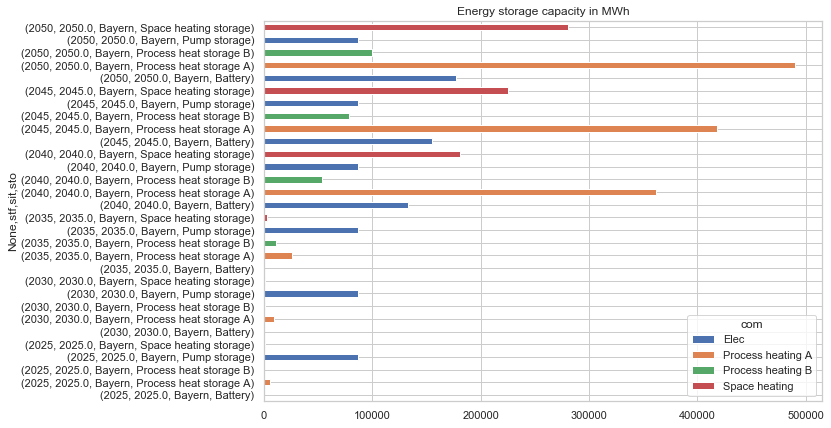

In [141]:
(pd.concat(sto_c_y)).plot.barh(stacked = True)
plt.title("Energy storage capacity in MWh")

Text(0.5, 1.0, 'Energy storage capacity in MW')

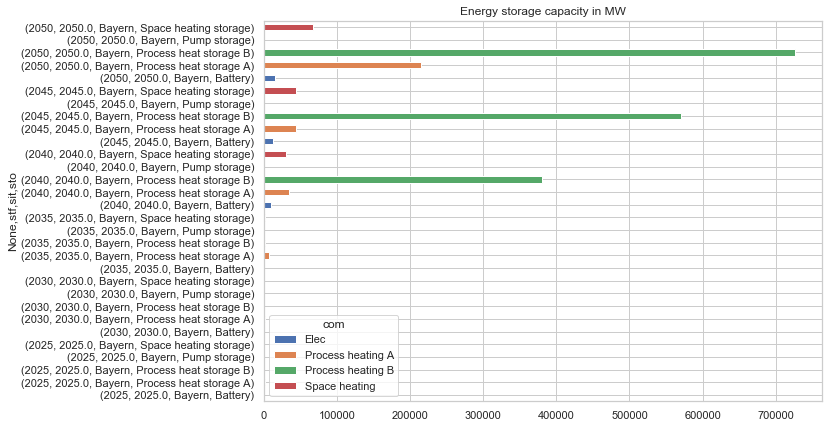

In [142]:
pd.concat(sto_p_y).plot.barh(stacked = True)
plt.title("Energy storage capacity in MW")

Text(0.5, 1.0, 'Annual electricity generation in TWh')

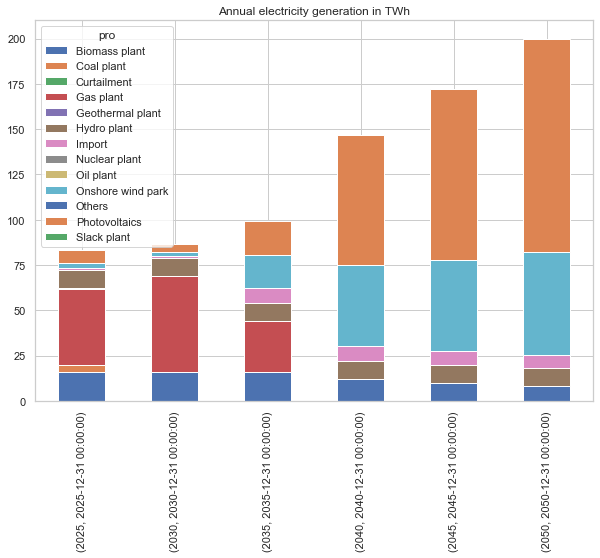

In [143]:
gen_y = {}

for year in years:
    gen_y[year] = (df[year]['e_pro_out']
        .unstack()['Elec']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        .resample('Y').sum()
        )
    
(pd.concat(gen_y) / 1e6).plot.bar(stacked = True)
plt.title("Annual electricity generation in TWh")

Text(0.5, 1.0, 'Annual electricity consumption in TWh')

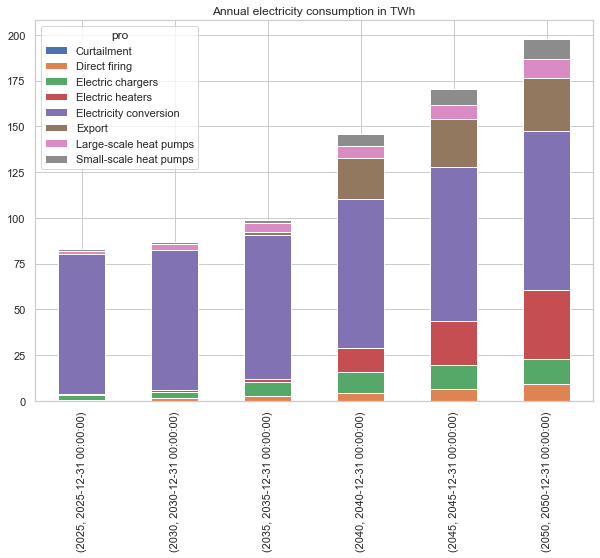

In [144]:
con_y = {}

for year in years:
    con_y[year] = (df[year]['e_pro_in']
        .unstack()['Elec']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        .resample('Y').sum()
        )
    
(pd.concat(con_y) / 1e6).plot.bar(stacked = True)
plt.title("Annual electricity consumption in TWh")

Text(0.5, 1.0, 'Power consumption capacity in MW')

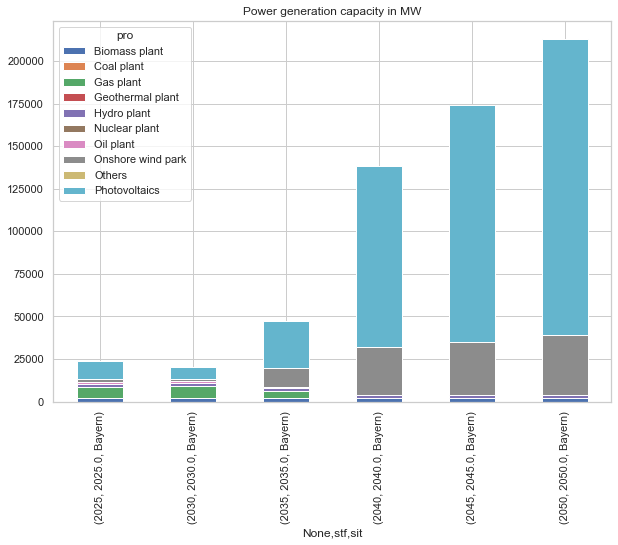

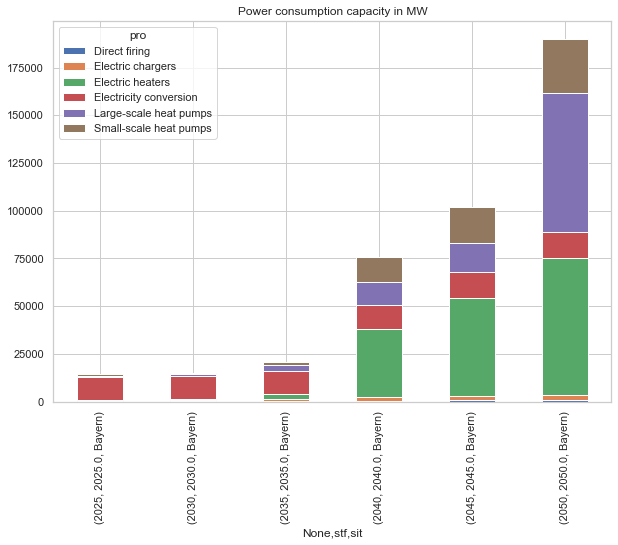

In [145]:
gen_cap_y = {}
con_cap_y = {}

for year in years:
    gen_cap_y[year] = df[year]['cap_pro'].unstack()[gen.columns].drop(['Curtailment', 'Slack plant', 'Import'], axis = 1)
    con_cap_y[year] = df[year]['cap_pro'].unstack()[con.columns].drop(['Curtailment', 'Export'], axis = 1)


pd.concat(gen_cap_y).plot.bar(stacked = True)
plt.title("Power generation capacity in MW")
pd.concat(con_cap_y).plot.bar(stacked = True)
plt.title("Power consumption capacity in MW")